In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('../')

In [3]:
import sys
sys.path.append('/home/njr61/rds/hpc-work/spurious-concepts/ConceptBottleneck')

In [75]:
import torch
import pickle
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import random
import numpy as np
from copy import deepcopy
from scipy.spatial.distance import cosine
import json

In [5]:
from ConceptBottleneck.CUB.dataset import load_data

In [6]:
from src.images import *
from src.util import *
from src.models import *
from src.plot import *

## Set up dataset + model

In [130]:
encoder_model='small7'
noisy=False
weight_decay = 0.0004
optimizer = 'sgd'

In [128]:
num_objects = 1
seed = 42

results_folder = "results/synthetic_filter/objects={}_seed={}".format(
    num_objects,seed
)

if not os.path.exists(results_folder):
    os.makedirs(results_folder)

In [129]:
dataset_name = "synthetic_{}".format(num_objects)

In [131]:
np.random.seed(seed)
torch.manual_seed(seed)

In [132]:
train_loader, val_loader, train_pkl, val_pkl = get_data(num_objects, noisy)
val_images, val_y, val_c = unroll_data(val_loader)

In [133]:
joint_model = get_synthetic_model(num_objects,encoder_model,noisy,weight_decay,optimizer,seed)

## Compare Adversarial and Blank Images

In [134]:
def valid_image_bounding_box(image,bounding_box):
    """Makes sure image is only within some bounding box
    
    Arguments:
        image: PyTorch Tensor
        bounding_box: 2D List of Lists with 4 elements (2x2) 
            The first 2 elements define the y_0 and y_1 of the bounding box
            The second 2 elements define the x_0 and x_1 

    Returns: PyTorch Tensor
    """

    image[:,:bounding_box[0][0],:] = 0.25
    image[:,bounding_box[0][1]:,:] = 0.25
    image[:,:,:bounding_box[1][0]] = 0.25
    image[:,:,bounding_box[1][1]:] = 0.25

    return image

In [135]:
ret_image = get_maximal_activation(joint_model,run_joint_model,1,
                                               lambda image: valid_image_bounding_box(image,[[0,128],[128,256]]),lamb=1)

In [136]:
ret_image = ret_image.detach()

In [137]:
blank_image = deepcopy(ret_image)
blank_image[:,:,:,:] = 0.25

In [138]:
adversarial_image = ret_image

In [139]:
output_blank = run_joint_model(joint_model,blank_image)[1].detach().numpy().tolist()
output_adversarial = run_joint_model(joint_model,adversarial_image)[1].detach().numpy().tolist()

In [140]:
first_layer_blank = joint_model.first_model.conv1(blank_image)
first_layer_adversarial = joint_model.first_model.conv1(adversarial_image)

In [141]:
filter_norms = [np.linalg.norm((first_layer_blank[0][i]-first_layer_adversarial[0][i]).detach().numpy()) for i in range(first_layer_blank.shape[1])]
filter_norms = np.array(filter_norms).tolist()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


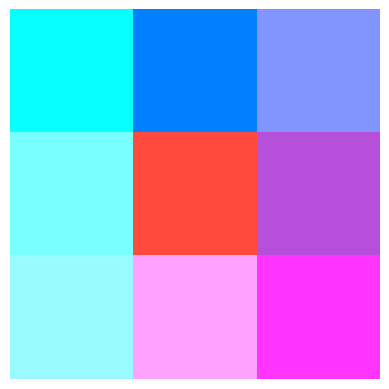

In [142]:
sorted_filters = np.argsort(filter_norms)[::-1]
for filter_num in sorted_filters[:5]:
    normalized_filter = joint_model.first_model.conv1.weight[filter_num].detach().numpy()
    normalized_filter /= np.max(normalized_filter) 
    normalized_filter -= np.min(normalized_filter)
    plt.imshow(normalized_filter.transpose((1,2,0)))
    plt.axis('off')
    plt.savefig('{}/{}.png'.format(results_folder,'filter_{}'.format(filter_num)),bbox_inches='tight')

In [143]:
filter_activations_adversarial = get_last_filter_activations(joint_model,run_joint_model,adversarial_image,1)
filter_activations_blank = get_last_filter_activations(joint_model,run_joint_model,blank_image,1)

In [144]:
mean_adversarial = np.mean(filter_activations_adversarial).tolist()
mean_blank = np.mean(filter_activations_blank).tolist()

In [145]:
cosine_similarity = cosine(filter_activations_adversarial,filter_activations_blank).tolist()

## Hybrid Models

In [146]:
joint_model_7 = joint_model 

In [147]:
def run_k_layers(model,input,k):
    x = input 
    
    for i in range(k):
        x = model.first_model.pool(torch.relu(getattr(model.first_model,'conv{}'.format(i+1))(x)))

    return x

In [148]:
log_folder = get_log_folder(dataset_name,weight_decay,'small5',optimizer)
joint_location = "ConceptBottleneck/{}/best_model_{}.pth".format(log_folder,seed)
joint_model_5 = torch.load(joint_location,map_location=torch.device('cpu'))
r = joint_model_5.eval()

model_5_output = run_joint_model(joint_model_5,adversarial_image)[1]
model_5_output = model_5_output.detach().numpy().tolist()

In [149]:
if num_objects == 1:
    log_folder = get_log_folder(dataset_name,weight_decay,'small6',optimizer)
    joint_location = "ConceptBottleneck/{}/best_model_{}.pth".format(log_folder,seed)
    joint_model_6 = torch.load(joint_location,map_location=torch.device('cpu'))
    r = joint_model_6.eval()

    model_6_output = run_joint_model(joint_model_6,adversarial_image)[1]
    model_6_output = model_6_output.detach().numpy().tolist()

In [150]:
model_7_output = run_joint_model(joint_model_7,adversarial_image)[1]
model_7_output = model_7_output.detach().numpy().tolist()

In [151]:
model_5_chimera_output = run_k_layers(joint_model_5,adversarial_image,5)
model_7_chimera_output = run_k_layers(joint_model_7,adversarial_image,5)

if num_objects == 1:
    model_6_chimera_output = run_k_layers(joint_model_6,adversarial_image,5)

In [152]:
def run_from_k(model,x,start_k,max_k):
    for i in range(start_k,max_k+1):
        x = model.first_model.pool(torch.relu(getattr(model.first_model,'conv{}'.format(i))(x)))
    x = x.view(-1, model.first_model.conv_output_size)
    out = []
    for fc in model.first_model.all_fc:
        out.append(fc(x)) 
    return out 

In [153]:
if num_objects == 1:
    chimera_5_6 = torch.stack(run_from_k(joint_model_6,model_5_chimera_output,6,6)).detach().numpy().tolist()
    chimera_6_7 = torch.stack(run_from_k(joint_model_7,model_6_chimera_output,7,7)).detach().numpy().tolist()

In [154]:
chimera_5_7 = torch.stack(run_from_k(joint_model_7,model_5_chimera_output,6,7)).detach().numpy().tolist()

In [155]:
final_output = {
    'filter_norms': filter_norms, 
    'mean_adversarial': mean_adversarial,
    'mean_blank': mean_blank, 
    'output_blank': output_blank,
    'output_adversarial': output_adversarial, 
    'cosine_similarity': cosine_similarity, 
    'model_5_output': model_5_output, 
    'model_7_output': model_7_output, 
    'chimera_5_7': chimera_5_7, 
}

if num_objects == 1:
    final_output['model_6_output'] = model_6_output
    final_output['chimera_5_6'] = chimera_5_6
    final_output['chimera_6_7'] = chimera_6_7

In [156]:
json.dump(final_output,open("{}/results.json".format(results_folder),"w"))